# xG model with a new feature 'championnat's score'

In [6]:
#%pip install xgboost
#%pip install tabulate
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm

In [7]:
with open('shots_model_2.json') as f:
    shots_model= json.load(f)

# Converting the laoded into datframe
shots_model = pd.DataFrame(shots_model)

shots_model

,Goal,X,Y,score_17_18,C,Distance,Angle,1H,2H
0,1,12.0,41.0,79.605,9.0,13.891814,0.474451,1,0
1,0,15.0,52.0,79.605,2.0,15.803560,0.453823,1,0
2,0,19.0,33.0,79.605,17.0,22.805811,0.280597,1,0
3,0,25.0,30.0,79.605,20.0,29.292704,0.223680,1,0
4,0,10.0,39.0,79.605,11.0,12.703248,0.479051,1,0
...,...,...,...,...,...,...,...,...,...
33937,0,7.0,66.0,106.998,16.0,12.735089,0.346975,0,1
33938,0,10.0,32.0,106.998,18.0,15.720687,0.317684,0,1
33939,1,8.0,25.0,106.998,25.0,18.292690,0.189128,0,1
33940,0,18.0,30.0,106.998,20.0,22.939268,0.263508,0,1


In [8]:
# Creating a dataframe containing all the features
X = shots_model[['C','score_17_18', '2H' ,'Distance','Angle']]
# Feature data set
X

,C,score_17_18,2H,Distance,Angle
0,9.0,79.605,0,13.891814,0.474451
1,2.0,79.605,0,15.803560,0.453823
2,17.0,79.605,0,22.805811,0.280597
3,20.0,79.605,0,29.292704,0.223680
4,11.0,79.605,0,12.703248,0.479051
...,...,...,...,...,...
33937,16.0,106.998,1,12.735089,0.346975
33938,18.0,106.998,1,15.720687,0.317684
33939,25.0,106.998,1,18.292690,0.189128
33940,20.0,106.998,1,22.939268,0.263508


In [9]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['C', 'Distance', 'Angle','score_17_18']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[-0.43355223, -0.73871869,  0.44413802,  0.09604288],
       [-1.33526891, -0.50239097,  0.35154924,  0.09604288],
       [ 0.59698112,  0.363219  , -0.42597354,  0.09604288],
       ...,
       [ 1.62751447, -0.19468766, -0.83652799,  1.76827238],
       [ 0.98343113,  0.37971679, -0.50267458,  1.76827238],
       [-0.69118557, -0.79996597,  0.59010791,  1.76827238]])

In [10]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['C','Angle','Distance','score_17_18'], axis=1)

# Adding scaled columns to our dataset
X['C'] = X_scaled[:,0]
X['Distance'] = X_scaled[:,1]
X['Angle'] = X_scaled[:,2]
X['score_17_18'] = X_scaled[:,3]

# Finalized Feature Dataset
X

,2H,C,Distance,Angle,score_17_18
0,0,-0.433552,-0.738719,0.444138,0.096043
1,0,-1.335269,-0.502391,0.351549,0.096043
2,0,0.596981,0.363219,-0.425974,0.096043
3,0,0.983431,1.165121,-0.681446,0.096043
4,0,-0.175919,-0.885648,0.464784,0.096043
...,...,...,...,...,...
33937,1,0.468164,-0.881712,-0.128036,1.768272
33938,1,0.725798,-0.512636,-0.259510,1.768272
33939,1,1.627514,-0.194688,-0.836528,1.768272
33940,1,0.983431,0.379717,-0.502675,1.768272


In [11]:
# Creating a data set containing dependent variable 'Goal'
y = shots_model['Goal']

y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int64

# Logistic Regression
I changed the penality from list [L_1,L_2] to only one penality [L_2] in grid parameters

In [12]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [13]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [14]:
# calculation of weight_0 and weight_1
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


In [15]:
param_grid_lr = {'C': [0.1, 1, 10, 100],
              'penalty': ['l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [16]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# Defining the logistic regression model
LR_model = LogisticRegression()
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(LR_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

array([0.34869359, 0.35570155, 0.34355828, 0.34352256, 0.34416476])

In [18]:
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the timer
end_time = time.time()

lr_training_time = end_time - start_time

In [19]:
# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 15.387 seconds


In [20]:
# Model Summary
# Get the estimated coefficients
coef = best_lr_model.coef_[0]
intercept = best_lr_model.intercept_[0]

# Calculate the standard errors
n = len(y_train)
A = np.hstack((np.ones((n, 1)), X_train))
p = len(coef)
y_pred = best_lr_model.predict(X_train)
residuals = y_train - y_pred
sigma2 = np.sum(residuals**2) / (n - p - 1)
cov = sigma2 * np.linalg.inv(np.dot(A.T, A))
se = np.sqrt(np.diag(cov)[1:])

# Calculate the Wald statistics and p-values
wald = coef / se
p_values = (1 - norm.cdf(np.abs(wald))) * 2

features = list(X_train.columns)

# Create a summary table of coefficients, standard errors, Wald statistics, and p-values
table = np.column_stack((features, coef, se, wald, p_values))
headers = ['Feature', 'Coef.', 'Std. Err.', 'Wald', 'p-value']
print(tabulate(table, headers=headers))

Feature           Coef.    Std. Err.       Wald      p-value
-----------  ----------  -----------  ---------  -----------
2H            0.165381    0.00656298    25.1991  0
C            -0.0785893   0.00382485   -20.547   0
Distance     -0.73904     0.00453825  -162.847   0
Angle         0.43854     0.00502761    87.2263  0
score_17_18  -0.0176966   0.00327818    -5.3983  6.72754e-08


In [21]:
#Brier score for Linear Regression on training data
LR_BRS_train = brier_score_loss(y_train, best_lr_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)), LR_BRS_train, end=  " is the Brier score on testing data ")

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     22817
           1       0.23      0.70      0.35      2639

    accuracy                           0.73     25456
   macro avg       0.59      0.71      0.59     25456
weighted avg       0.88      0.73      0.78     25456
 0.18401423436838618 is the Brier score on testing data 

In [22]:
# Classfication report for training data
y_pred = best_lr_model.predict(X_test)
LR_BRS_test = brier_score_loss(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred),  LR_BRS_test, end=  " is the brier score on testing data ")

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      7672
           1       0.22      0.71      0.34       814

    accuracy                           0.73      8486
   macro avg       0.59      0.72      0.58      8486
weighted avg       0.89      0.73      0.78      8486
 0.1848628553091816 is the brier score on testing data 

# XGboost Model

In [23]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [25]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.646078059871163

In [26]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [5, 7, 9],
              'n_estimators': [100, 200, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [27]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [28]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 8.646078059871163}
Model Training Time: 534.575 seconds


In [29]:
 #Brier score for xgboost on training data
xgb_BRS_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)), xgb_BRS_train, end=  " is the brier score on training data")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     22817
           1       0.23      0.75      0.36      2639

    accuracy                           0.72     25456
   macro avg       0.60      0.73      0.59     25456
weighted avg       0.89      0.72      0.77     25456
 0.17939124465223044 is the brier score on training data

In [30]:
# On testing data
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_BRS_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (classification_report(y_test, y_pred_xgb), xgb_BRS_test , end= " is the brier score on test data")

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      7672
           1       0.21      0.72      0.33       814

    accuracy                           0.72      8486
   macro avg       0.59      0.72      0.58      8486
weighted avg       0.89      0.72      0.77      8486
 0.18239128115674336 is the brier score on test data

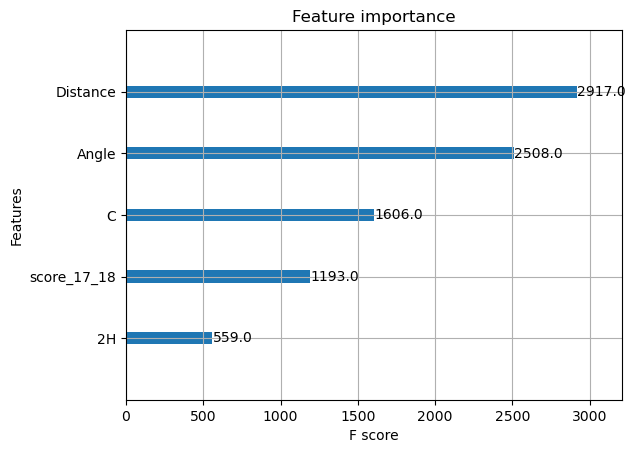

In [31]:
# Plottingg important features
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

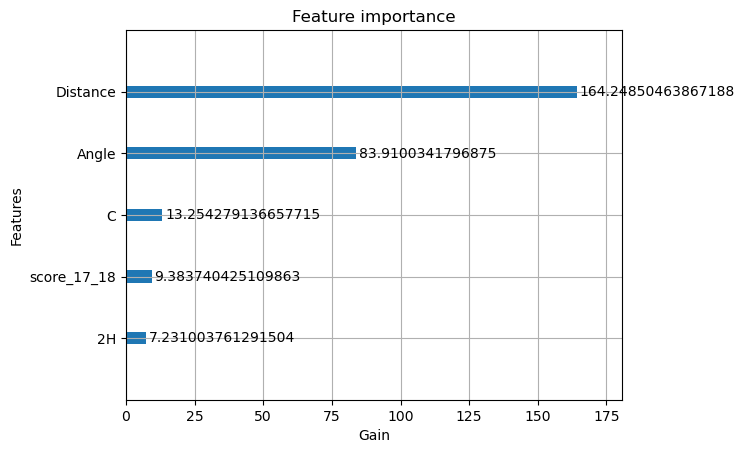

In [32]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

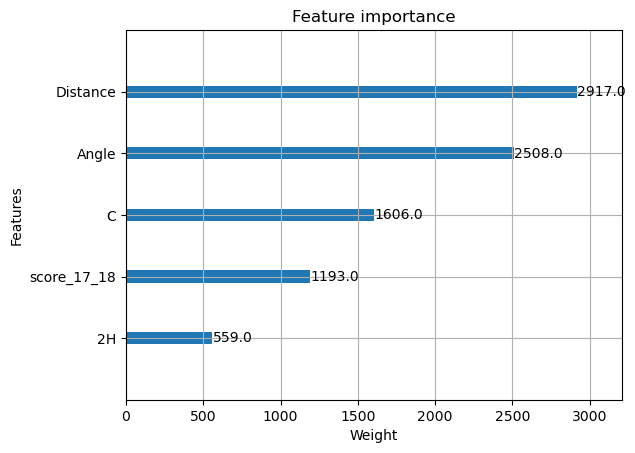

In [33]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# Random Forest Model

In [34]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


In [36]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [7, 9, 12, 15, 17],
              'min_samples_split': [3, 5, 10],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [37]:
# Define the random forest model
rf_model = RandomForestClassifier()
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [38]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [39]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}
Model Training Time: 659.939 seconds


In [40]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (classification_report(y_train, best_rf_model.predict(X_train)),rf_brs_train, end= " is the brier score on training data" )

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     22817
           1       0.24      0.74      0.37      2639

    accuracy                           0.74     25456
   macro avg       0.60      0.74      0.60     25456
weighted avg       0.89      0.74      0.79     25456
 0.16905621087641431 is the brier score on training data

In [41]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred_rf), rf_brs_test, end= " is the brier score on testing data")

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      7672
           1       0.22      0.70      0.33       814

    accuracy                           0.73      8486
   macro avg       0.59      0.72      0.58      8486
weighted avg       0.89      0.73      0.79      8486
 0.17356799905514717 is the brier score on testing data

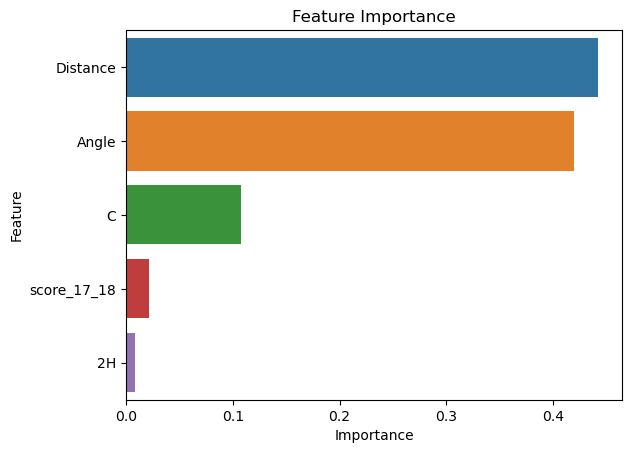

In [42]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

In [43]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

#prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

#prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

#rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

#rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

#acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

#acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test]
# Brier score for four models on training data
BRS_train = [LR_BRS_train, xgb_BRS_train, rf_brs_train]
# Brier score for four models on test data
BRS_test = [LR_BRS_test, xgb_BRS_test, rf_brs_test]


# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60]

In [44]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,'Training Brier': BRS_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test, 'Testing Brier': BRS_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')

,Training Accuracy,Training Precision,Training Recall,Training Brier,Testing Accuracy,Testing Precision,Testing Recall,Testing Brier,Training Time (mins)
Model Name,,,,,,,,,
Logistic Regression,0.728,0.231,0.698,0.184,0.728,0.219,0.715,0.185,0.256
XG Boost,0.719,0.233,0.746,0.179,0.718,0.213,0.720,0.182,8.910
Random Forests,0.736,0.244,0.737,0.169,0.733,0.220,0.699,0.174,10.999
